To start, we import the `matplotlib` library, which is essential for visualizing different aspects of our calculations, such as molecular geometry, as well as the resulting phonon properties. By setting `plt.rcParams['figure.dpi'] = 120`, we adjust the resolution of the figures to ensure they are displayed with sufficient clarity and detail.

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120

As previously mentioned, we use the PLAMS Python library to interact with AMS. The code below constructs the beryllium oxide (BeO) crystal structure by defining a `Molecule` object. Individual atoms, beryllium (Be) and oxygen (O), are then added to the molecule using their respective symbols and Cartesian coordinates, which are specified in Angstroms. Next, the crystal lattice is defined as a 3x3 matrix, with dimensions also in Angstroms.

In [2]:
from scm.plams import Molecule, Atom, plot_molecule

mol = Molecule()
mol.add_atom(Atom(symbol="Be", coords=(0.00000000, 1.55554138, 0.00070090)))
mol.add_atom(Atom(symbol="Be", coords=(1.34713836, 0.77777069, 2.18871035)))
mol.add_atom(Atom(symbol= "O", coords=(0.00000000, 1.55554138, 1.65124622)))
mol.add_atom(Atom(symbol= "O", coords=(1.34713836, 0.77777069, 3.83925567)))
mol.lattice = [[ 2.69427671, 0.00000000, 0.00000000], \
               [-1.34713836, 2.33331208, 0.00000000], \
               [ 0.00000000, 0.00000000, 4.37601889]]

To visualize the BeO crystal structure we've defined, we employ the `plot_molecule` function. This function serves as an interface to the `plot_atoms` function from the Atomic Simulation Environment (ASE), enabling us to generate graphical representations of the atomic arrangement. For a more detailed control over the generated figures, you can consult the original ASE documentation. In this particular instance, we generate three distinct views of the BeO structure by applying different rotation angles. Specifically, we create a figure with three subplots, each displaying the molecule rotated along different axes: `('15x,15y,0z')`, `('0x,90y,0z')`, and `('0x,0y,0z')`.

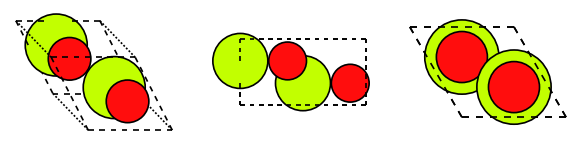

In [3]:
fig, ax_arr = plt.subplots(1, 3)
ax_arr[0] = plot_molecule(mol, ax=ax_arr[0], rotation=('15x,15y,0z'))
ax_arr[1] = plot_molecule(mol, ax=ax_arr[1], rotation=('0x,90y,0z'))
ax_arr[2] = plot_molecule(mol, ax=ax_arr[2], rotation=('0x,0y,0z'))

To set up the Quantum Espresso phonon calculation, we first create a Settings object in PLAMS to store all the calculation parameters. We begin by specifying a `GeometryOptimization` task to ensure our BeO structure is at a local energy minimum, preventing any spurious imaginary frequencies in the phonon spectrum. Next, we activate the calculation of phonons (`Properties%Phonons = Yes`), which will provide us with the phonon band structure and density of states (DOS).

For the electronic structure part, we set the plane-wave energy cutoff (`ecutwfc`) to `25 Ry`. While this value is lower than typically recommended for production calculations (`40 Ry`), we use it here for demonstration purposes to reduce computational cost. The Brillouin zone sampling is done using a Monkhorst-Pack k-point grid of size `4 × 4 × 3`, ensuring a balanced sampling in all directions. Additionally, we also use a `4 × 4 × 3` q-point grid for our phonons calculation. A coarser q-point grid is normally preferred to the k-point grid (electronic part), as phonon calculations are more computationally intensive. However, the right choice should be obtained by a convergence test.

AMS uses the specified q-grid for the initial analytical calculation of phonon frequencies within Quantum Espresso. However, the band structure plot is generated by interpolating those frequencies onto a denser set of q-points along the high-symmetry path proposed by Setyawan and Curtarolo (convention `Phonons%BandStructure%KPathFinderConvention = 'Setyawan-Curtarolo'`). This interpolation scheme, using a Fourier interpolation, allows for the construction of continuous phonon dispersion curves, providing a clearer visualization of the phonon band structure and facilitating the analysis of vibrational modes across different regions of the reciprocal space.

The pseudopotentials used in this calculation are based on the SSSP-Efficiency family with the PBE functional and no relativistic corrections, as this is the default choice in AMS. Finally, we create an `AMSJob` object named `"BeO"` that combines the settings and the previously defined BeO molecule, encapsulating all the information needed to run the Quantum Espresso calculation.

In [4]:
from scm.plams import Settings, AMSJob

s = Settings()
s.input.ams.Task = "GeometryOptimization"
s.input.ams.Properties.Phonons = "Yes"
s.input.QuantumEspresso.System.ecutwfc = 25.0
s.input.QuantumEspresso.K_Points._h = "automatic"
s.input.QuantumEspresso.K_Points._1 = "4 4 3 0 0 0"
s.input.QuantumEspresso.Phonons.Q_Points._h = "automatic"
s.input.QuantumEspresso.Phonons.Q_Points._1 = "4 4 3 0 0 0"

job = AMSJob(settings=s, molecule=mol, name="BeO")

The `job.get_input()` function retrieves the content of the AMS input file generated during the previous setup. This enables users to inspect the input parameters before running the Quantum Espresso calculation. Reviewing the input file can be beneficial for advanced users who seek greater control over the calculation settings.

In [5]:
print(job.get_input())

Properties
  Phonons Yes
End

Task GeometryOptimization

System
  Atoms
             Be       0.0000000000       1.5555413800       0.0007009000
             Be       1.3471383600       0.7777706900       2.1887103500
              O       0.0000000000       1.5555413800       1.6512462200
              O       1.3471383600       0.7777706900       3.8392556700
  End
  Lattice
         2.6942767100     0.0000000000     0.0000000000
        -1.3471383600     2.3333120800     0.0000000000
         0.0000000000     0.0000000000     4.3760188900
  End
End

Engine QuantumEspresso
  K_Points automatic
     4 4 3 0 0 0
  End
  Phonons
    Q_Points automatic
       4 4 3 0 0 0
    End
  End
  System
    ecutwfc 25.0
  End
EndEngine




We call the `run()` method on the previously defined `AMSJob` object to start the Quantum Espresso calculation. This starts the execution of the job, and once it is completed, the results are stored in the results object. The output displays various stages of the job's progress, including `STARTED`, `RUNNING`, `FINISHED`, and finally, `SUCCESSFUL`, which indicates that the calculation has been completed without any errors.

In [6]:
results = job.run()

[27.03|10:20:29] JOB BeO STARTED
[27.03|10:20:29] JOB BeO RUNNING
[27.03|10:26:38] JOB BeO FINISHED
[27.03|10:26:38] JOB BeO SUCCESSFUL


The phonon band structure is widely used because it provides a clear understanding of how vibrational modes (phonons) propagate and interact within a crystalline material. 

To visualize the phonon band structure, we can use the `plot_phonons_band_structure` function provided by PLAMS. This function takes the phonon band structure data, which we can obtain from the results object using the `get_phonons_band_structure` method, and generates a plot of the phonon frequencies along the specified high-symmetry path in the Brillouin zone. The `unit="cm^-1"` argument ensures that the frequencies are displayed in units of wavenumbers.

The `plot_phonons_band_structure` function uses matplotlib for plotting, so we can further customize the plot using matplotlib's functionalities. In this case, we set the y-axis and x-axis labels, and the title of the plot. This plot provides a visual representation of the phonon band structure, allowing us to analyze the dispersion of phonon frequencies across the Brillouin zone and identify key features such as acoustic and optical modes, band gaps, and degeneracies.

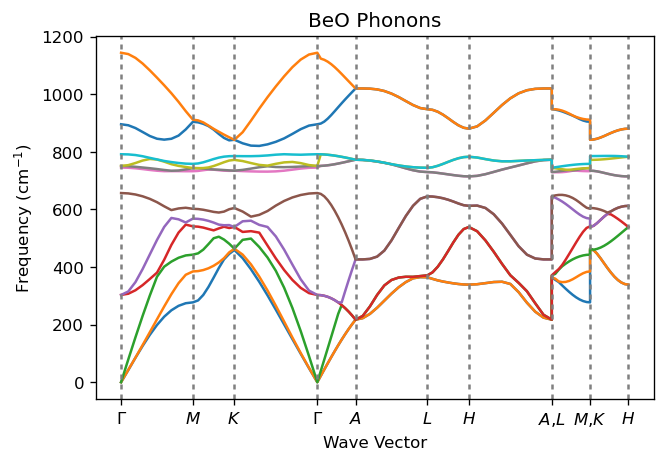

In [7]:
from scm.plams import plot_phonons_band_structure

phonons_data = results.get_phonons_band_structure(unit="cm^-1")
ax = plot_phonons_band_structure(*phonons_data)

ax.set_ylabel("Frequency (cm$^{-1}$)")
ax.set_xlabel("Wave Vector")
ax.set_title("BeO Phonons")

plt.show()

The image displays a comprehensive view of the vibrational properties of BeO. The color lines indicate the dispersion of phonon frequencies across different high-symmetry directions in the Brillouin zone. Distinct branches correspond to acoustic and optical phonon modes: acoustic modes approach zero frequency at the center ($\Gamma$ point), while optical modes exhibit non-zero frequencies.

Theoretical results for comparison can be found in [The Computational Raman Database](https://ramandb.oulu.fi/) (mpid: mp-2542).

We can also visualize the phonon density of states (DOS). The following code displays the DOS with a breakdown by atomic species. The function `get_phonons_dos` retrieves the DOS data from the `results` object, with frequencies measured in cm$^{-1}$. Then, the `plot_phonons_dos` function generates the plot, using the parameter `dos_type="species"` to specify that the contributions from different atomic species (in this case, Be and O) should be shown separately. This breakdown allows for an analysis of how each species contributes to the overall property.

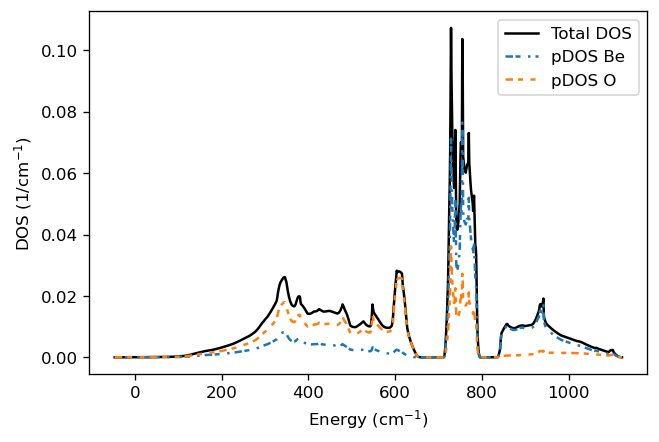

In [8]:
from scm.plams import plot_phonons_dos

phonons_dos_data = results.get_phonons_dos( unit="cm-1" )
ax = plot_phonons_dos(*phonons_dos_data, dos_type="species")
ax.set_ylabel("DOS (1/cm$^{-1}$)")
ax.set_xlabel("Energy (cm$^{-1}$)")

plt.show()

This figure shows three distinct regions separated by two gaps (no vibrational modes). At lower frequencies, the first region typically has contributions from acoustic and optical modes (confirmed with the phonon band structure above). Optical modes primarily dominate the second and third regions. In particular, we can see the intense characteristic peak associated with wurtzite structures around 650 cm$^{-1}$. This peak is mainly attributed to the E$^2_h$ optical phonon mode, which is quite flat in the band structure. This mode involves vibrations perpendicular to the c-axis and is exclusively Raman-active. Additionally, looking at the partial DOS components, we can see that the Be atoms dominate the highest frequency region.

After examining the phonon band structure and the DOS, we will now focus on the thermodynamic properties derived from the latter, as described at the beginning of this tutorial. The following code retrieves the calculated thermodynamic properties from the results object and visualizes them. The `get_phonons_thermodynamic_properties` function extracts the relevant data, specifying energy in units of kJ/mol and entropy and heat capacity in J/K/mol. Next, the `plot_phonons_thermodynamic_properties` function generates a comprehensive plot of these properties as a function of temperature.

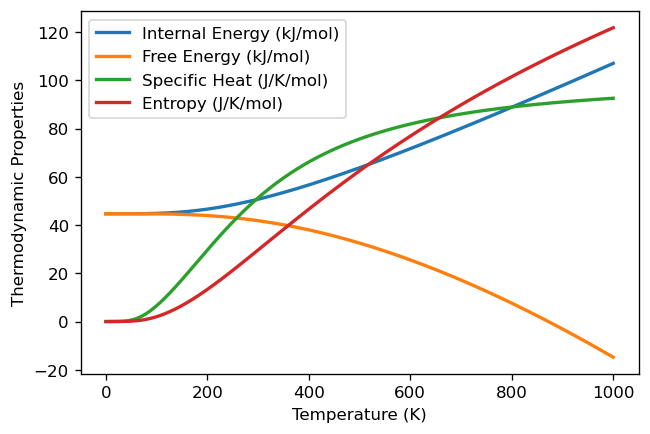

In [9]:
from scm.plams import plot_phonons_thermodynamic_properties

properties_data = results.get_phonons_thermodynamic_properties( properties_unit=["kJ/mol", "J/K/mol"] )
ax = plot_phonons_thermodynamic_properties(*properties_data)
ax.set_ylabel("Thermodynamic Properties")
ax.set_xlabel("Temperature (K)")

plt.show()

These properties offer valuable insights into the thermal behavior of the material. From the previous figure, we can see a couple of interesting features:

Firstly, the internal energy ($U$) increases steadily with temperature, starting from the Zero Point Energy (ZPE) at 0 K (44.70 kJ/mol). This trend aligns with the increase in vibrational energy of the atoms as the temperature rises.

Secondly, the specific heat ($C_v$) exhibits a characteristic behavior commonly observed in many solids. It increases rapidly at low temperatures due to the gradual excitation of vibrational modes. As the temperature continues to rise, the specific heat approaches a plateau known as the Dulong-Petit limit. This limit represents the classical regime in which all vibrational modes are fully excited. For BeO, our calculations indicate that the Dulong-Petit limit is approximately 99.77 J/K/mol of unit cells, which corresponds to 3n*R, where n is the number of atoms per unit cell and R is the ideal gas constant. To express this limit per mole of atoms, as is traditionally done, we divide by n to arrive at the well-known value of 3R.

The analytical approach to phonon calculations using DFPT is efficient, but AMS also offers the option to perform numerical phonon calculations. While this numerical method is more computationally intensive (taking roughly twice longer than the analytical version) it can be valuable for specific scenarios or for validating the results obtained from analytical calculations. For those interested in exploring this alternative method, the following code demonstrates how to set up and execute a numerical phonon calculation, along with the corresponding results.

[27.03|10:26:39] JOB BeO_num STARTED
[27.03|10:26:39] JOB BeO_num RUNNING
[27.03|10:39:37] JOB BeO_num FINISHED
[27.03|10:39:37] JOB BeO_num SUCCESSFUL


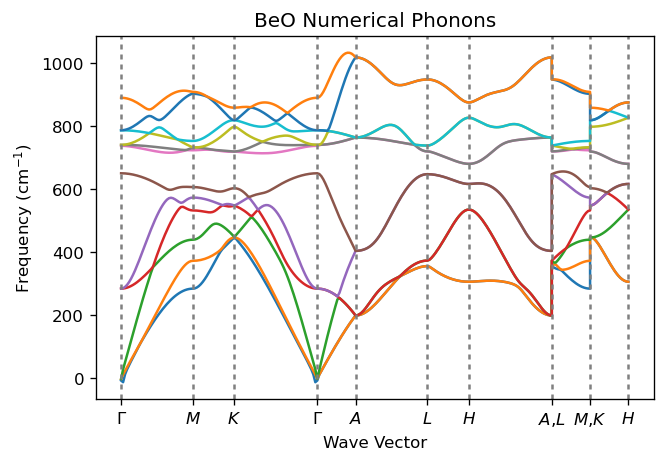

In [10]:
from scm.plams import Settings, AMSJob
from scm.plams import plot_phonons_band_structure

s = Settings()
s.input.ams.Task = "GeometryOptimization"
s.input.ams.Properties.Phonons = "Yes"
s.input.ams.Phonons.Method = "Numerical"
s.input.ams.NumericalPhonons.SuperCell._1 = "2 0 0"
s.input.ams.NumericalPhonons.SuperCell._2 = "0 2 0"
s.input.ams.NumericalPhonons.SuperCell._3 = "0 0 2"
s.input.QuantumEspresso.System.ecutwfc = 25.0
s.input.QuantumEspresso.K_Points._h = "automatic"
s.input.QuantumEspresso.K_Points._1 = "4 4 3 0 0 0"

job_num = AMSJob(settings=s, molecule=mol, name="BeO_num")
results_num = job_num.run()

phonons_data = results_num.get_phonons_band_structure(unit="cm^-1")
ax = plot_phonons_band_structure(*phonons_data)

ax.set_ylabel("Frequency (cm$^{-1}$)")
ax.set_xlabel("Wave Vector")
ax.set_title("BeO Numerical Phonons")

plt.show()